This study addresses the prevalent issue of greenwashing within the Environmental, Social, and Governance (ESG) reports of German DAX companies. Greenwashing—defined as the practice of misrepresenting sustainability efforts to appear more environmentally friendly than reality—poses significant challenges for stakeholders, including investors, regulators, and the public. These misrepresented reports lead to misinformed decisions that can have widespread economic and environmental consequences. This project utilizes Natural Language Processing (NLP) techniques to analyze approximately 11,000 English-language ESG documents and auxiliary third-party media content. By employing advanced methods such as sentiment analysis, text embeddings, and large language models (LLMs), the study aims to detect inconsistencies and exaggerated sustainability claims effectively. The objective is to enhance transparency in corporate sustainability reports and provide stakeholders with a tool to assess the authenticity of corporate environmental claims. This initiative is crucial for ensuring that ESG data accurately reflect companies' actual sustainability practices, thereby supporting informed decision-making and promoting genuine corporate responsibility. The expected outcomes include a deeper understanding of greenwashing practices and improved methodologies for evaluating corporate sustainability reports. 

In [1]:
#!pip install sentence_transformers

In [2]:
# Make sure that all dependencies are installed.
import pandas as pd
import os
import numpy as np
import sentence_transformers
import torch
import plotly.graph_objects as go

/home/san/miniconda3/envs/hackitba/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading the data

In [3]:
esg_documents_df = pd.read_csv("esg_documents_for_dax_companies.csv", sep="|")
esg_documents_df.head()

,Unnamed: 0,company,content,datatype,date,domain,esg_topics,internal,symbol,title,url
0,2,Beiersdorf AG,Sustainability Highlight Report CARE BEYOND SK...,sustainability_report,2021-03-31,NaN,"['CleanWater', 'GHGEmission', 'ProductLiabilit...",1,BEI,BeiersdorfAG Sustainability Report 2021,NaN
1,3,Deutsche Telekom AG,Corporate Responsibility Report 2021 2 Content...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'Iso50001', 'GlobalWarming', ...",1,DTE,DeutscheTelekomAG Sustainability Report 2021,NaN
2,5,Vonovia SE,VONOVIA SE SUSTAINABILITY REPORT 2021 =For a S...,sustainability_report,2021-03-31,NaN,"['Whistleblowing', 'DataSecurity', 'Vaccine', ...",1,VNA,VonoviaSE Sustainability Report 2021,NaN
3,6,Merck KGaA,Sustainability Report 2021 TABLE OF CONTENTS S...,sustainability_report,2021-03-31,NaN,"['DataSecurity', 'DataMisuse', 'DrugResistance...",1,MRK,MerckKGaA Sustainability Report 2021,NaN
4,9,MTU,Our ideas and concepts FOR A SUSTAINABLE FUTUR...,sustainability_report,2020-03-31,NaN,"['WorkLifeBalance', 'Corruption', 'AirQuality'...",1,MTX,MTUAeroEngines Sustainability Report 2020,NaN


In [4]:
# form texts by concatenating title and content
esg_texts = esg_documents_df.apply(lambda row: " ".join([str(row["title"]), str(row["content"])]), axis=1)
esg_texts[0][:100]

'BeiersdorfAG Sustainability Report 2021 Sustainability Highlight Report CARE BEYOND SKIN 2021 03 For'

In [5]:
sdg_df = pd.read_csv("sdg_descriptions_with_targetsText.csv")
sdg_df.head()

,id,name,description,targets,targets_json_array,progress
0,1,No Poverty,End poverty in all its forms everywhere,"['1.1', 'By 2030, eradicate extreme poverty fo...","[{""target"":""1.1"",""description"":""By 2030, eradi...",['The impact of the COVID-19 pandemic reversed...
1,2,Zero Hunger,"End hunger, achieve food security and improved...","['2.1', 'By 2030, end hunger and ensure access...","[{""target"":""2.1"",""description"":""By 2030, end h...","['Between 2014 and the onset of the pandemic, ..."
2,3,Good Health and Well-being,Ensure healthy lives and promote well-being fo...,"['3.1', 'By 2030, reduce the global maternal m...","[{""target"":""3.1"",""description"":""By 2030, reduc...","['By April 2022, the coronavirus causing COVID..."
3,4,Quality Education,Ensure inclusive and equitable quality educati...,"['4.1', 'By 2030, ensure that all girls and bo...","[{""target"":""4.1"",""description"":""By 2030, ensur...",['The COVID-19 outbreak has caused a global ed...
4,5,Gender Equality,Achieve gender equality and empower all women ...,"['5.1', 'End all forms of discrimination again...","[{""target"":""5.1"",""description"":""End all forms ...","[""The world is not on track to achieve gender ..."


In [6]:
sdg_texts = sdg_df.apply(lambda row: " ".join([row["name"], row["description"], row["targets"], row["progress"]]), axis=1)
sdg_texts[0][:100]

"No Poverty End poverty in all its forms everywhere ['1.1', 'By 2030, eradicate extreme poverty for a"

In [7]:
companies = sorted(esg_documents_df.company.unique())
companies

['Adidas AG',
 'Airbus SE',
 'AkzoNobelNV',
 'Allianz SE',
 'BASF SE',
 'BMW',
 'Bayer AG',
 'Beiersdorf AG',
 'Brenntag',
 'Continental AG',
 'Covestro AG',
 'Daimler AG',
 'Deutsche Bank AG',
 'Deutsche Boerse AG',
 'Deutsche Post AG',
 'Deutsche Telekom AG',
 'E ONSE',
 'Fresenius',
 'Hannover R AG',
 'Heidelberg Cement AG',
 'Henkel',
 'Infineon Technologies AG',
 'Linde',
 'MTU',
 'Merck KGaA',
 'Muenchener Rueckversicherungs Gesellschaft AGin Muenchen',
 'Porsche',
 'Puma SE',
 'Qiagen',
 'RWE AG',
 'SAP',
 'Sartorius AG',
 'Siemens AG',
 'Siemens Energy',
 'Siemens Healthineers AG',
 'Symrise AG',
 'Volkswagen AG',
 'Vonovia',
 'Vonovia SE',
 'Zalando SE']

## 2. Build embeddings

MPNet base model loaded here is designed to capture a broad understanding of language from diverse datasets, making it suitable for ESG and SDG texts that may contain varied and specialized terminology.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# load the retriever model from huggingface model hub
retriever = sentence_transformers.SentenceTransformer("flax-sentence-embeddings/all_datasets_v3_mpnet-base", device=device)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Error while downloading from https://cdn-lfs.hf.co/flax-sentence-embeddings/all_datasets_v3_mpnet-base/fe3fc5248610ed8c279c12d6d2b39096ca561a4466ae7c28120907d76b3490c1?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1743275600&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MzI3NTYwMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9mbGF4LXNlbnRlbmNlLWVtYmVkZGluZ3MvYWxsX2RhdGFzZXRzX3YzX21wbmV0LWJhc2UvZmUzZmM1MjQ4NjEwZWQ4YzI3OWMxMmQ2ZDJiMzkwOTZjYTU2MWE0NDY2YWU3YzI4MTIwOTA3ZDc2YjM0OTBjMT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=pRrqIvYWczZQu2BNY4sW7F1D-0NP9ckddSOIjJNA7tx%7EkNrzOqqK5iMJ51E8uXI-0Fd%7EnwxC7DwZoLu3oCV5HAVVR8qhFU0MJlYTavNN4nbYf6a7UICpsh0GTCoW-SlIzOryVP0uBXaajMFPM4LxjLmozNmbAjJnkTDbVDM-HaDkYazfB41tITObVE2IcPVr6gfFjU2wF2gri3M0YwnhPB55mCxNyqf7MgnmfCHOhcpiWUPcPkZHNv6tvUnnSXS%7ENbsZMar96vccy71AaT9cF5ogK--y%7ESu5LnHRPWOL4lsNHtteaBt%7Egh591H79tpA-

In [9]:
company_text_embeddings = retriever.encode(esg_texts)
sdg_embeddings = retriever.encode(sdg_texts)

In [10]:
print(device)

cuda


## 3. SDG alignment of the DAX companies

* We model SDG alignment as similarity between the company-related texts and the SDG descriptions. In this section, we first define the similarity function using standard cosine similarity. Then, we demonstrate some possible alignment analyses, their visualisations and interpretations. Finally, we provide suggestions for further, more advanced alignment analyses.

In [11]:
def cosine_similarity(embedding1, embedding2):
    sim = np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    return sim

### Most relevant SDGs for DAX companies

Let's first consider the overall relevance of the 17 SDGs for all DAX companies taken together. We first compute an embedding that averages over all company texts. Then, we compare this embedding with the embeddings of the SDGs.
Instead of using a simple mean to combine company text embeddings, considered weighting the texts by their length or importance. This will give more relevant documents a greater influence on the resulting average embedding

In [12]:
# Calculate the length of each document
text_lengths = np.array([len(text) for text in esg_texts])
# Normalize the lengths to sum to 1
weights = text_lengths / text_lengths.sum()
print(weights.sum())

1.0


In [13]:
all_companies_embedding = np.average(company_text_embeddings, axis=0, weights=weights)

In [14]:
sdg_relevance_scores = [cosine_similarity(all_companies_embedding, sdg_embedding) for sdg_embedding in sdg_embeddings]
sdg_relevance_series = pd.Series(sdg_relevance_scores, index=sdg_df["name"])
sdg_relevance_series.sort_values(inplace=True)
sdg_relevance_series.head()

name
Gender Equality                           0.218582
Peace, Justice and Strong Institutions    0.238494
Life On Land                              0.259296
Quality Education                         0.284037
Zero Hunger                               0.314142
dtype: float64

cosine similarity scores highlight which SDGs are most discussed in company reports, reflecting alignment with SDG language rather than actual efforts or impact. Lower scores for SDGs like Gender Equality suggest underrepresentation in communications, meriting further investigation into potential neglect or underreporting. Conversely, higher scores for SDGs like Zero Hunger indicate a stronger emphasis in companies' sustainability strategies and reporting.

In [15]:
fig = go.Figure(data=[go.Bar(x=sdg_relevance_series, y=[sdg+" " for sdg in sdg_relevance_series.index], orientation='h')])
# Change the bar mode
fig.update_layout(height=600, width=750, title="SDG relevance for DAX index")
fig.update_xaxes(title="Relevance")
fig.show()

# Clustering

In [16]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming company_text_embeddings is a 2D numpy array of embeddings
# Decide on the number of clusters you want to form
n_clusters = 5  # for example, though this number should be chosen based on your data

# Initialize the KMeans clustering algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model on your embeddings to perform the clustering
kmeans.fit(company_text_embeddings)

# Get the cluster labels for each company
cluster_labels = kmeans.labels_

# Optionally, attach the cluster labels to your original dataframe for analysis
esg_documents_df['Cluster'] = cluster_labels

# To analyze the clusters, you might want to look at the companies in each cluster
for i in range(n_clusters):
    print(f"Cluster {i}:")
    print(esg_documents_df[esg_documents_df['Cluster'] == i]['company'].values)
    print()

# If you want to see the centroids of each cluster which are the average of the embeddings in the cluster:
centroids = kmeans.cluster_centers_


Cluster 0:
['Daimler AG' 'Zalando SE' 'Zalando SE' ... 'Zalando SE' 'Zalando SE'
 'Zalando SE']

Cluster 1:
['Daimler AG' 'Volkswagen AG' 'Porsche' ... 'Vonovia' 'Zalando SE'
 'Zalando SE']

Cluster 2:
['Beiersdorf AG' 'Deutsche Telekom AG' 'Vonovia SE' ... 'Zalando SE'
 'Zalando SE' 'Zalando SE']

Cluster 3:
['Qiagen' 'Bayer AG' 'Fresenius' ... 'Vonovia' 'Zalando SE' 'Zalando SE']

Cluster 4:
['Heidelberg Cement AG' 'Linde' 'Fresenius' ... 'Zalando SE' 'Zalando SE'
 'Zalando SE']



In [17]:
esg_documents_df.to_csv('esg_documents_with_clusters.xlsx', index=False)

In [18]:
import pandas as pd

# Assuming esg_documents_df has a 'Cluster' column with the cluster labels
cluster_membership_table = esg_documents_df[['company', 'Cluster']].copy()
cluster_membership_table.sort_values('Cluster', inplace=True)

# Save the table to a CSV file for easy sharing and viewing
cluster_membership_table.to_csv('cluster_membership_table.csv', index=False)

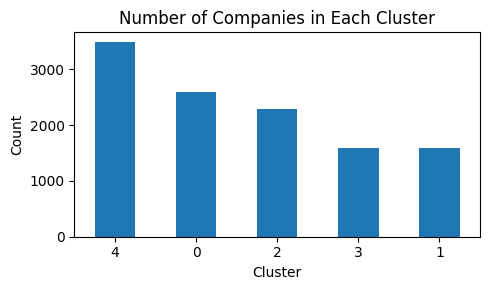

In [20]:
import matplotlib.pyplot as plt

# Count the number of companies in each cluster
cluster_counts = esg_documents_df['Cluster'].value_counts()

# Create a bar plot
plt.figure(figsize=(5, 3))
cluster_counts.plot(kind='bar')
plt.title('Number of Companies in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep the x labels readable
plt.tight_layout()
plt.savefig('cluster_sizes_bar_plot.png')
plt.show()

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

# Updated function to display common words for each cluster, excluding stop words
def display_common_words(df, cluster_col='Cluster', text_col='content', n_words=10):
    cluster_common_words = {}
    for cluster in sorted(df[cluster_col].unique()):
        # Combine all the text data for each cluster
        text_data = df[df[cluster_col] == cluster][text_col].str.cat(sep=' ')
        # Use CountVectorizer to count word frequencies, excluding stop words
        vectorizer = CountVectorizer(stop_words='english')
        word_count = vectorizer.fit_transform([text_data])
        # Sum up the word counts and get the word names
        words_freq = word_count.toarray().sum(axis=0)
        words = vectorizer.get_feature_names_out()
        # Combine counts and words, sort by count, and get the most common
        freq_dist = zip(words, words_freq)
        most_common_words = sorted(freq_dist, key=lambda x: x[1], reverse=True)[:n_words]
        # Store and print the most common words
        cluster_common_words[cluster] = most_common_words
        print(f"Cluster {cluster}:")
        for word, freq in most_common_words:
            print(f"{word}: {freq}")
        print("\n")
    return cluster_common_words

# Call the function with the dataframe
common_words_by_cluster = display_common_words(esg_documents_df, 'Cluster', 'content')

Cluster 0:
market: 6820
new: 6247
said: 6014
scholar: 5625
google: 5004
time: 4553
pubmed: 4463
et: 4307
10: 4166
company: 4098


Cluster 1:
group: 11602
porsche: 7156
bmw: 6410
year: 6197
management: 6027
new: 5899
2021: 5637
market: 5632
financial: 5563
electric: 5198


Cluster 2:
energy: 14944
sustainability: 11133
management: 10714
2021: 9605
business: 9284
report: 8790
company: 8486
year: 8337
employees: 8318
2020: 8271


Cluster 3:
scholar: 12185
google: 10714
patients: 10063
market: 9453
data: 9435
al: 9360
pubmed: 9172
et: 9006
19: 8967
health: 8391


Cluster 4:
financial: 26677
2021: 25439
year: 21929
company: 21293
management: 21185
report: 20804
board: 20102
market: 19996
group: 19984
2020: 19729




### Most relevant SDGs for a specific company, contrasting internal and external data

In this analysis, we focus on a specific company which is defined using the COMPANY variable. We look up the "internal" and "external" embeddings for this company, average them and measure their similarity with each of the SDGs.

In [22]:
COMPANY = "Brenntag"

internal_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 1)].index
internal_company_embedding = np.mean(company_text_embeddings[internal_company_indices], axis=0)

external_company_indices = esg_documents_df[(esg_documents_df.company == COMPANY) & (esg_documents_df.internal == 0)].index
external_company_embedding = np.mean(company_text_embeddings[external_company_indices], axis=0)

company_sdg_relevance_scores = [[cosine_similarity(internal_company_embedding, sdg_embedding),
                                 cosine_similarity(external_company_embedding, sdg_embedding)] for sdg_embedding in sdg_embeddings]
company_sdg_relevance_df = pd.DataFrame.from_records(company_sdg_relevance_scores, index=sdg_df["name"], columns=["internal", "external"])
company_sdg_relevance_df.sort_values("internal", inplace=True)
company_sdg_relevance_df.head()

,internal,external
name,,
Gender Equality,0.107339,0.093954
"Peace, Justice and Strong Institutions",0.135041,0.130411
Good Health and Well-being,0.153959,0.203413
Zero Hunger,0.155495,0.193237
Climate Action,0.160574,0.240062


In [23]:
fig = go.Figure(data=[
    go.Bar(name='Internal', x=company_sdg_relevance_df["internal"], y=company_sdg_relevance_df.index, orientation='h'),
    go.Bar(name='External', x=company_sdg_relevance_df["external"], y=company_sdg_relevance_df.index, orientation='h')
])

fig.update_layout(barmode='group', height=600, width=750, title=f"SDG Relevance for {COMPANY}")
fig.update_xaxes(title="Relevance")
fig.show()

These scores indicate which SDGs are most closely associated with Brenntag's sustainability narrative, from both the company's perspective and that of external media. The higher scores on external metrics for certain goals could suggest a disparity between how the company perceives its ESG efforts and how these efforts are perceived or reported by external parties. This discrepancy is particularly valuable for identifying potential areas of greenwashing or for highlighting the aspects of sustainability that may need more attention from the company.

Next steps to further explore the data: modify the chart to answer the following questions:

- What are the internally most important SDGs for BMW?
- What are the most important SDGs for BMW when we take into account both the internal and the external data?
- What are the SDGs for BMW with the largest relevance gap between internal and external data?

In [24]:
import pandas as pd
import numpy as np

# Assuming you have already computed 'company_sdg_relevance_scores' as shown in your notebook snippet
COMPANY = 'BMW'
internal_indices = esg_documents_df[(esg_documents_df['company'] == COMPANY) & (esg_documents_df['internal'] == 1)].index
external_indices = esg_documents_df[(esg_documents_df['company'] == COMPANY) & (esg_documents_df['internal'] == 0)].index

# Aggregate internal and external embeddings for BMW
internal_bmw_embedding = np.mean(company_text_embeddings[internal_indices], axis=0)
external_bmw_embedding = np.mean(company_text_embeddings[external_indices], axis=0)

# Assuming 'sdg_embeddings' is a 2D numpy array with embeddings for each SDG
company_sdg_relevance_scores = [
    (
        sdg_df.loc[idx]["name"],  # SDG Name
        cosine_similarity(internal_bmw_embedding, sdg_embeddings[idx]),  # Internal similarity score
        cosine_similarity(external_bmw_embedding, sdg_embeddings[idx])   # External similarity score
    )
    for idx in range(len(sdg_embeddings))  # Assuming the index aligns with the SDGs order
]

# Create DataFrame from relevance scores
company_sdg_relevance_df = pd.DataFrame.from_records(
    company_sdg_relevance_scores,
    columns=['SDG', 'Internal', 'External']
)

# Calculate the relevance gap between internal and external data
company_sdg_relevance_df['Relevance Gap'] = company_sdg_relevance_df['Internal'] - company_sdg_relevance_df['External']

# Internally most important SDGs for BMW
internally_important_sdgs = company_sdg_relevance_df.sort_values('Internal', ascending=False)

# Most important SDGs for BMW considering both internal and external data
# A simple way to estimate overall importance might be to average the internal and external scores
company_sdg_relevance_df['Average Importance'] = company_sdg_relevance_df[['Internal', 'External']].mean(axis=1)
overall_important_sdgs = company_sdg_relevance_df.sort_values('Average Importance', ascending=False)

# SDGs for BMW with the largest relevance gap between internal and external data
sdgs_largest_relevance_gap = company_sdg_relevance_df.sort_values('Relevance Gap', ascending=False)

# Output the top results for each analysis
print("Internally Most Important SDGs for BMW:")
print(internally_important_sdgs.head(), "\n")

print("Most Important SDGs for BMW (Internal and External):")
print(overall_important_sdgs.head(), "\n")

print("SDGs with the Largest Relevance Gap for BMW:")
print(sdgs_largest_relevance_gap.head(), "\n")


Internally Most Important SDGs for BMW:
                                        SDG  Internal  External  Relevance Gap
8   Industry, Innovation and Infrastructure  0.317917  0.337423      -0.019506
6               Affordable and Clean Energy  0.309701  0.308345       0.001357
11   Responsible Consumption and Production  0.293384  0.284081       0.009303
2                Good Health and Well-being  0.262602  0.231365       0.031237
9                      Reduced Inequalities  0.258250  0.257018       0.001232 

Most Important SDGs for BMW (Internal and External):
                                        SDG  Internal  External  \
8   Industry, Innovation and Infrastructure  0.317917  0.337423   
6               Affordable and Clean Energy  0.309701  0.308345   
11   Responsible Consumption and Production  0.293384  0.284081   
10       Sustainable Cities and Communities  0.239840  0.304329   
9                      Reduced Inequalities  0.258250  0.257018   

    Relevance Gap  Average I


•	Internally Most Important SDGs for BMW

1.	Industry, Innovation, and Infrastructure: 
This is highlighted as the most important SDG in BMW's internal documents, suggesting a significant focus on innovation and sustainable infrastructure within their business practices. This emphasis likely reflects BMW's development of electric vehicles and the establishment of eco-friendly production facilities, aligning with industry trends toward greener and more efficient infrastructures.

2.	Affordable and Clean Energy: 
This SDG is also prioritized highly by BMW, reflecting a focus on energy efficiency and clean energy initiatives within their operations. For example, BMW has invested in renewable energy solutions across its manufacturing plants, such as using wind turbines to power facilities like the Leipzig plant in Germany.

3.	Responsible Consumption and Production: 
BMW emphasizes responsible production by implementing sustainable practices such as reducing waste, increasing recycling, and using eco-friendly materials like water-based paints and recycled plastics in their vehicles, underscoring their commitment to minimizing environmental impact.

4.	Sustainable Cities and Communities: 
BMW's internal reports suggest a commitment to supporting sustainable cities and communities, likely through mobility solutions and urban infrastructure projects.

5.	Good Health and Well-being: 
Finally, good health and well-being are considered important, suggesting that BMW values health-related aspects of sustainability, perhaps related to product safety and employee wellness.

•	Most Important SDGs for BMW (Considering Both Internal and External Data)

When both internal and external data are considered, the SDGs that emerge as most important for BMW largely mirror those identified as internally important:

•	Industry, Innovation, and Infrastructure
•	Affordable and Clean Energy
•	Responsible Consumption and Production 
•	Sustainable Cities and Communities 
•	Reduced Inequalities 

These SDGs represent areas where BMW's sustainability reporting and the external perception of its ESG efforts align, indicating a consistent public-facing narrative on these goals.

•	SDGs with the Largest Relevance Gap for BMW

The SDGs with the most substantial relevance gaps between BMW's internal and external narratives are:

1.  Decent Work and Economic Growth: This has the most considerable gap, which suggests external parties has a significantly different perception of BMW's impact on economic growth and employment quality compared to how BMW reports it.

2.  Quality Education: A notable gap in this area indicates that BMW's contributions to education, perhaps through corporate social responsibility initiatives, are not as recognized externally as they are emphasized internally.

3.  Clean Water and Sanitation: The relevance gap suggests that BMW's efforts or impact on water and sanitation are perceived differently externally compared to the company's internal reporting.

4.  Responsible Consumption and Production: Although this is a highly ranked SDG internally, the gap indicates that external perceptions may not fully align with BMW's reported efforts in this area.

These gaps highlight areas where BMW might need to improve their sustainability practices, increase transparency, or adjust their external communication strategies to better align external perceptions with their internal reporting.


In [25]:
# Replace 'BMW' with 'Porsche'
COMPANY = 'Porsche'

internal_indices = esg_documents_df[(esg_documents_df['company'] == COMPANY) & (esg_documents_df['internal'] == 1)].index
external_indices = esg_documents_df[(esg_documents_df['company'] == COMPANY) & (esg_documents_df['internal'] == 0)].index

internal_porsche_embedding = np.mean(company_text_embeddings[internal_indices], axis=0)
external_porsche_embedding = np.mean(company_text_embeddings[external_indices], axis=0)

porsche_sdg_relevance_scores = [
    (
        sdg_df.loc[idx]["name"],  # SDG Name
        cosine_similarity(internal_porsche_embedding, sdg_embeddings[idx]),  # Internal similarity score
        cosine_similarity(external_porsche_embedding, sdg_embeddings[idx])   # External similarity score
    )
    for idx in range(len(sdg_embeddings))  # Assuming the index aligns with the SDGs order
]

# Create DataFrame from relevance scores
porsche_sdg_relevance_df = pd.DataFrame.from_records(
    porsche_sdg_relevance_scores,
    columns=['SDG', 'Internal', 'External']
)

# Calculate the relevance gap between internal and external data
porsche_sdg_relevance_df['Relevance Gap'] = porsche_sdg_relevance_df['Internal'] - porsche_sdg_relevance_df['External']

# Sort by Internal, Average, and Relevance Gap
internally_important_sdgs = porsche_sdg_relevance_df.sort_values('Internal', ascending=False)
porsche_sdg_relevance_df['Average Importance'] = porsche_sdg_relevance_df[['Internal', 'External']].mean(axis=1)
overall_important_sdgs = porsche_sdg_relevance_df.sort_values('Average Importance', ascending=False)
sdgs_largest_relevance_gap = porsche_sdg_relevance_df.sort_values('Relevance Gap', ascending=False)

# Assuming you want to output or examine the top results:
print("Internally Most Important SDGs for Porsche:")
print(internally_important_sdgs.head(), "\n")

print("Most Important SDGs for Porsche (Internal and External):")
print(overall_important_sdgs.head(), "\n")

print("SDGs with the Largest Relevance Gap for Porsche:")
print(sdgs_largest_relevance_gap.head(), "\n")


Internally Most Important SDGs for Porsche:
                                        SDG  Internal  External  Relevance Gap
11   Responsible Consumption and Production  0.294036  0.255754       0.038282
6               Affordable and Clean Energy  0.268432  0.280989      -0.012557
8   Industry, Innovation and Infrastructure  0.235534  0.240739      -0.005205
9                      Reduced Inequalities  0.228679  0.234930      -0.006251
13                         Life Below Water  0.224651  0.192963       0.031688 

Most Important SDGs for Porsche (Internal and External):
                                        SDG  Internal  External  \
11   Responsible Consumption and Production  0.294036  0.255754   
6               Affordable and Clean Energy  0.268432  0.280989   
8   Industry, Innovation and Infrastructure  0.235534  0.240739   
9                      Reduced Inequalities  0.228679  0.234930   
16               Partnerships for the Goals  0.219921  0.225301   

    Relevance Gap  A

### Heatmap of SDG relevance for all companies

In this analyses, we look at the alignment of all companies with the 17 SDGs, creating an overview over the DAX index.

In [26]:
company_embeddings = []
for company in companies:
    company_indices = esg_documents_df[esg_documents_df.company == company].index
    company_embedding = np.mean(company_text_embeddings[company_indices], axis=0)
    company_embeddings.append(company_embedding)

In [27]:
company_records = []

for company_embedding in company_embeddings:
    company_record = []
    for sdg_embedding in sdg_embeddings:
        company_record.append(cosine_similarity(company_embedding, sdg_embedding))
    company_records.append(company_record)

In [28]:
heatmap_array = np.array(company_records)
heatmap_array.shape

(40, 17)

In [29]:
fig = go.Figure(data=go.Heatmap(
        z=heatmap_array,
        x=sdg_df["name"].tolist(),
        y=[company + " " for company in companies],
        colorscale='Viridis'))

fig.update_layout(height=1000)

fig.show()

The heatmap also shows variance across companies for each SDG, indicating that different companies may prioritize different SDGs based on their industry, strategy, and operational focus. For instance, if a certain company has a higher alignment with "Life Below Water," it may suggest their business has a direct impact on marine ecosystems, like shipping or resource extraction.

1.  Affordable and Clean Energy (SDG 7): This goal has the highest total relevance score, it is the most emphasized SDG across DAX companies. Companies are likely focusing on energy efficiency, renewable energy, and clean technology initiatives in their sustainability efforts.

2.  Industry, Innovation, and Infrastructure (SDG 9): Coming in second, this indicates a strong focus on building resilient infrastructure, fostering innovation, and supporting industrial development, which is key to economic growth and sustainable development.

3.  Reduced Inequalities (SDG 10): The third most relevant SDG reflects a significant commitment from these companies to reduce income disparities, promote social, economic, and political inclusion, and ensure equal opportunities.

4.  Responsible Consumption and Production (SDG 12) and Life Below Water (SDG 14): These goals also rank high, showing a focus on sustainable resource use, efficient waste management, and marine conservation.

5.  Partnerships for the Goals (SDG 17): This SDG, while not the highest, still scores relatively well, indicating engagement in partnerships to achieve broader sustainability targets.

6.  Gender Equality (SDG 5) and Peace, Justice, and Strong Institutions (SDG 16): These goals have the lowest total relevance scores. This could mean they are not as prominently reported or targeted in the companies' sustainability strategies or perhaps are areas where the companies need to develop stronger initiatives.



Next steps to further explore the data: modify the chart to answer the following questions:

- What are the companies that are most aligned with the SDGs? (sort by sum of rows)
- Which SDGs are most relevant for the DAX index? (sort by sum of columns)

In [30]:
import numpy as np
import pandas as pd

# Assuming 'company_text_embeddings' are the embeddings for the company contents
# and 'sdg_embeddings' are the embeddings for the concatenated SDG texts

# Compute cosine similarity for each company and each SDG
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Calculate the alignment score with all SDGs for each company
company_alignment_scores = []

for company in esg_documents_df['company'].unique():
    company_indices = esg_documents_df[esg_documents_df['company'] == company].index
    company_embedding = np.mean(company_text_embeddings[company_indices], axis=0)
    
    company_sdg_scores = [
        cosine_similarity(company_embedding, sdg_embedding) for sdg_embedding in sdg_embeddings
    ]
    
    total_alignment_score = np.sum(company_sdg_scores)
    company_alignment_scores.append((company, total_alignment_score))

# Create a DataFrame from the alignment scores
company_alignment_df = pd.DataFrame(company_alignment_scores, columns=['Company', 'Total Alignment Score'])

# Sort the companies by their total alignment score in descending order
sorted_alignment_df = company_alignment_df.sort_values(by='Total Alignment Score', ascending=False)

# Now sorted_alignment_df contains companies sorted by their alignment with the SDGs
# You can print or save this DataFrame to CSV or Excel for further analysis
sorted_alignment_df.to_csv('companies_sorted_by_sdg_alignment.csv', index=False)


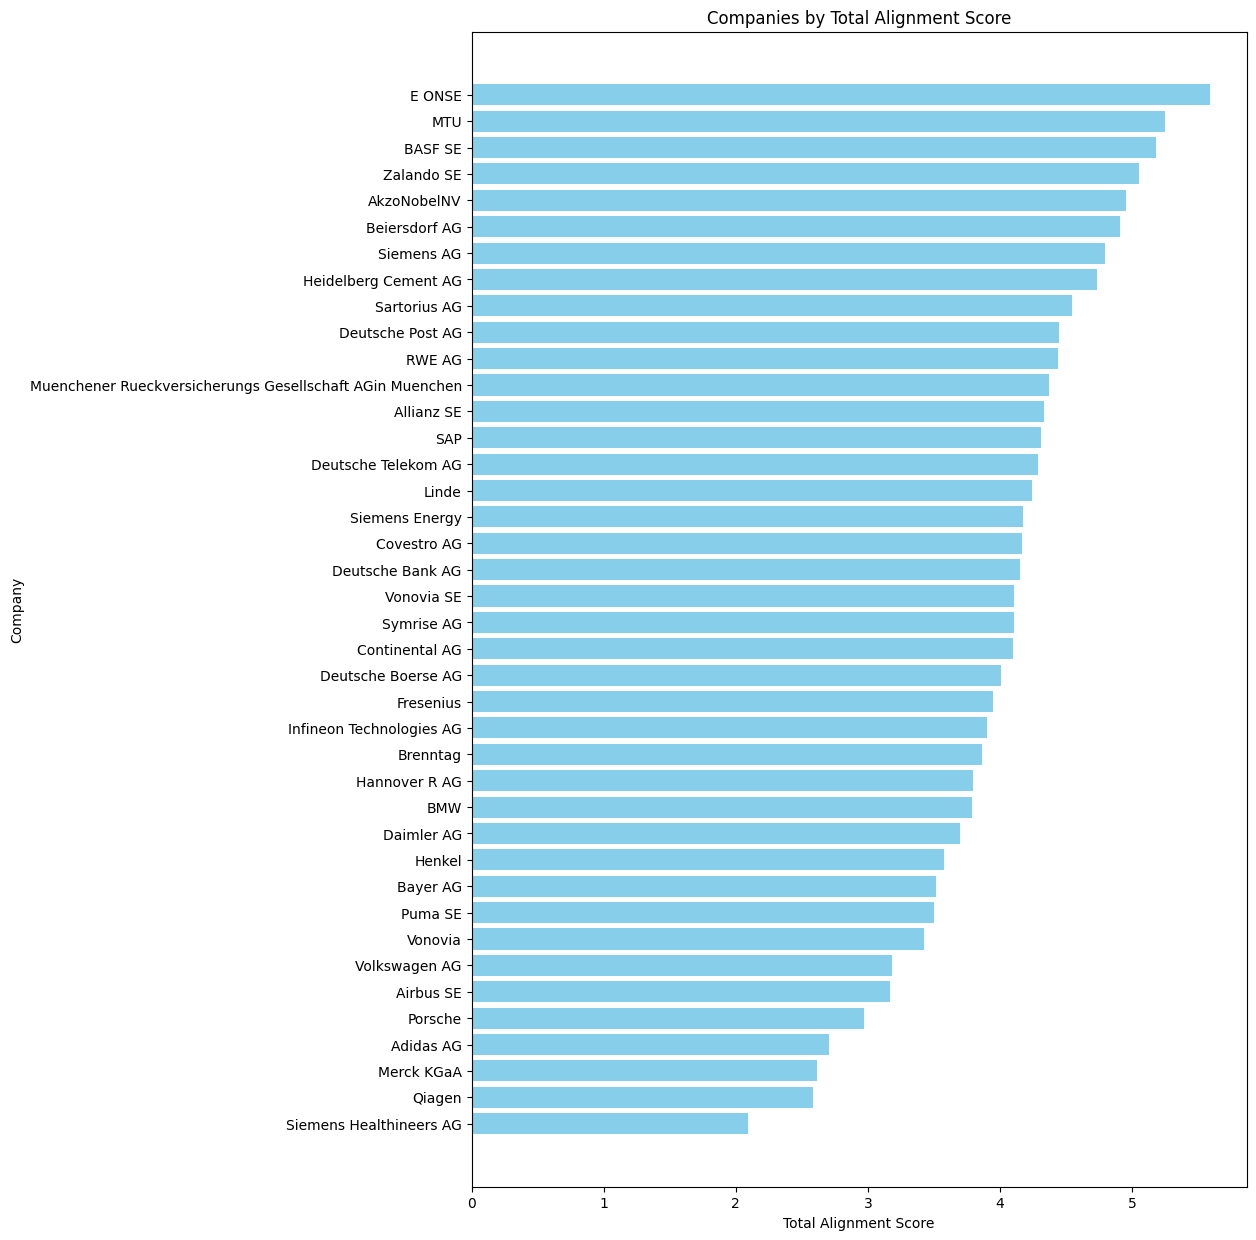

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 15))  # Adjust the figure size as needed
plt.barh(sorted_alignment_df['Company'], sorted_alignment_df['Total Alignment Score'], color='skyblue')
plt.xlabel('Total Alignment Score')
plt.ylabel('Company')
plt.title('Companies by Total Alignment Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score on top
plt.show()


In [32]:
# Assume 'company_text_embeddings' are available and are a list of embeddings for each company
# And 'sdg_embeddings' is a list of embeddings for each SDG

# Compute cosine similarity scores between each company and each SDG
all_company_scores = np.array([
    [cosine_similarity(company_embedding, sdg_embedding) for sdg_embedding in sdg_embeddings]
    for company_embedding in company_text_embeddings
])

# Sum scores for each SDG across all companies
sdg_relevance_sums = np.sum(all_company_scores, axis=0)

# Create a DataFrame for SDGs and their summed relevance scores
sdg_relevance_df = pd.DataFrame({
    'SDG': sdg_df['name'],  # or however you have the SDG names stored
    'Total Relevance': sdg_relevance_sums
})

# Sort the DataFrame by the 'Total Relevance' column in descending order
sorted_sdgs_by_relevance = sdg_relevance_df.sort_values(by='Total Relevance', ascending=False)

# Reset the index to get a clean DataFrame
sorted_sdgs_by_relevance.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
sorted_sdgs_by_relevance


,SDG,Total Relevance
0,Affordable and Clean Energy,1891.833252
1,"Industry, Innovation and Infrastructure",1740.805908
2,Reduced Inequalities,1582.340942
3,Responsible Consumption and Production,1579.344727
4,Life Below Water,1564.692627
5,Partnerships for the Goals,1525.674683
6,Clean Water and Sanitation,1374.699951
7,Good Health and Well-being,1371.963013
8,Decent Work and Economic Growth,1334.091431
9,No Poverty,1333.696533


The output appears to be a table that lists the Sustainable Development Goals (SDGs) in descending order of their relevance across the companies in the DAX index, based on a summation of the cosine similarity scores between company reports and SDG embeddings.

Here's an interpretation of the output:

1. **Affordable and Clean Energy (SDG 7)**: This is the most relevant SDG across the DAX companies, suggesting that these companies are placing a strong emphasis on energy-related issues and clean energy solutions in their operations and reporting.

2. **Industry, Innovation and Infrastructure (SDG 9)**: As the second most relevant SDG, it indicates a significant focus on building resilient infrastructure, promoting inclusive and sustainable industrialization, and fostering innovation among the DAX companies.

3. **Reduced Inequalities (SDG 10)**: Standing as the third, it shows a considerable commitment by the companies to address inequalities within and among countries.

4. **Responsible Consumption and Production (SDG 12)**: This high ranking reflects an emphasis on sustainable management and efficient use of natural resources, as well as a push for more sustainable practices and consumption patterns.

5. **Life Below Water (SDG 14)**: The companies are also paying substantial attention to conserving and sustainably using the oceans, seas, and marine resources, as indicated by its relevance score.

6. **Partnerships for the Goals (SDG 17)**: This indicates the importance placed on multi-stakeholder partnerships that mobilize and share knowledge, expertise, technology, and financial resources to support the achievement of the SDGs in all countries.

7. **Clean Water and Sanitation (SDG 6)** to **Gender Equality (SDG 5)**: The middle-ranked SDGs show moderate to high relevance, suggesting these areas are also recognized within corporate sustainability efforts but with varying degrees of focus.

8. **Life On Land (SDG 15)** and **Peace, Justice and Strong Institutions (SDG 16)**: These SDGs have lower total relevance scores, indicating they are less emphasized across the DAX companies compared to other goals.

9. **Gender Equality (SDG 5)**: As the SDG with the lowest total relevance score, this may suggest that gender equality is not as prominently addressed within the sustainability reports of the DAX companies or is not as aligned with their core business activities as other SDGs.

This interpretation suggests that while there is some focus across the spectrum of SDGs, certain goals related to environmental sustainability, innovation, and infrastructure are given more emphasis in the corporate sustainability reports of DAX companies. Goals related to social issues like gender equality appear to receive less emphasis relative to others.

To gain a more nuanced understanding of why some SDGs score higher than others, it would be beneficial to analyze the content of the reports qualitatively to understand the specific contexts, initiatives, and reporting practices of the DAX companies. Additionally, considering the sectors in which these companies operate could provide further insights into why certain SDGs are more relevant to them.


Conclusion and Recommendations

•	Suggestions for companies, policymakers, and ESG rating providers on how to reduce greenwashing:

To effectively mitigate the issue of greenwashing, companies should adopt a multi-faceted approach encompassing increased transparency, rigorous third-party audits, broad stakeholder engagement, and the strategic implementation of NLP tools. By enhancing the transparency of sustainability reports and providing detailed methodologies behind ESG claims, companies can foster greater accountability. 
Engaging independent third parties to audit these claims and involving a diverse range of stakeholders—such as NGOs, community representatives, and industry experts—in the reporting process further ensures a well-rounded representation of the company’s sustainability efforts. 
Crucially, developing internal NLP tools to continuously analyze and compare their ESG reporting with external media and reports can help companies identify discrepancies and better align their corporate reporting with external perceptions and facts. Policymakers can support these efforts by funding research focused on advanced NLP techniques for monitoring ESG disclosures and promoting regulatory frameworks that mandate the disclosure of both positive and negative sustainability impacts. Similarly, ESG rating providers should integrate these sophisticated NLP methodologies to enhance the analysis of qualitative data in ESG reports, enabling more accurate comparisons with quantitative data and third-party information, thereby ensuring a more reliable assessment of corporate sustainability practices.

